# Entries

1. Historical statistics of direct confrontation (team 1 vs team 2)
2. Statistics of *N* previous matches for each team
3. Home player or away player
4. Current points on championship
5. Match day matters?

In [1]:
from pprint import pprint
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Opening MongoDB
MATCHES_COLLECTION_NAME = 'matches'
CLASSIFICATION_HISTORY_COLLECTION_NAME = 'rankings'
DB_NAME = 'soccer-prediction'

client = MongoClient()
db = client[DB_NAME]
matches_collection = db[MATCHES_COLLECTION_NAME]
classification_history = db[CLASSIFICATION_HISTORY_COLLECTION_NAME]

(array([4416., 2032., 2744., 2488., 1472., 3200., 2792., 1728., 1320.,
        1160.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <a list of 10 Patch objects>)

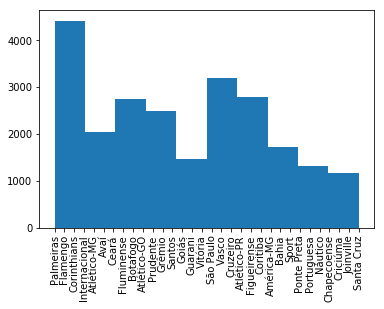

In [3]:
# Total number of matches per team
years = matches_collection.distinct('year')
freq = []
for year in years:
    year_teams = matches_collection.aggregate([{'$project':{'home_team':1}}])
    freq.extend([i['home_team'] for i in year_teams])

plt.xticks(rotation=90)
plt.hist(freq)

In [4]:
# Sample match for testing
sample = matches_collection.find_one()
pprint(sample)

{'_id': ObjectId('5ac9529b6b5b9e2af46c59f1'),
 'arbiter': 'Péricles Bassols Pegado Cortez',
 'away_team': 'Vitória',
 'cards': [{'player': 'Reniê', 'team': 'VIT', 'type': 'yellow'},
           {'player': 'Deola', 'team': 'PAL', 'type': 'yellow'},
           {'player': 'Edinho', 'team': 'PAL', 'type': 'yellow'},
           {'player': 'Wallace Reis ', 'team': 'VIT', 'type': 'red'}],
 'coaches': {'away_team': 'Ricardo Silva', 'home_team': 'Antônio Carlos Zago'},
 'home_team': 'Palmeiras',
 'location': {'city': 'São Paulo, SP', 'stadium': 'Palestra Itália'},
 'players': {'away_team': [{'name': 'Viáfara', 'position': 'GOL'},
                           {'name': 'Reniê', 'position': 'ZAD'},
                           {'name': 'Wallace Reis', 'position': 'ZAD'},
                           {'name': 'Egídio', 'position': 'LAE'},
                           {'name': 'Rafael Granja', 'position': 'MEC'},
                           {'name': 'Edson Reis', 'position': 'ATA'},
                          

In [5]:
# Default match feature extractor
def extract_features(match):
    N = 4
    stats = match['statistics']
    score = match['score']
    home_team_last_sg = get_last_N_balances(match['home_team'], N)
    away_team_last_sg = get_last_N_balances(match['away_team'], N)
    return [
            score['home_team'],
            score['away_team'], 
            stats['goals_home_team'], 
            stats['goals_away_team'],
            stats['wins_home_team'], 
            stats['wins_away_team'], 
            stats['previous_draws'], 
            *home_team_last_sg, 
            *away_team_last_sg
           ]

In [6]:
# Gets the last N balances of a team per match 
# The results are sorted from the most recent to the oldest match result
def get_last_N_balances(team, limit):
    query_constraints = {'$or':[ {'away_team':team}, {'home_team':team}]}
    query_projections = {'home_team':1, 'away_team':1, 'year':1, 'round':1, 'score':1, 'teams': 1}
    query_sort_criteria = [('year',-1), ('round',-1)]

    matches = matches_collection.find(query_constraints, query_projections)\
                                .sort(query_sort_criteria)\
                                .limit(limit)
    sgs =[]
    for match in matches:
        score = match['score']
        is_home = team == match['home_team']
        
        if is_home:
            sg = score['home_team'] - score['away_team']
        else:
            sg = score['away_team'] - score['home_team']
        sgs.append(sg)
    
    return sgs

In [7]:
print(extract_features(sample))

[1, 0, 47, 31, 14, 4, 8, -1, 1, 1, 0, 1, 2, -1, 0]


In [10]:
from keras.models import Sequential
from keras.layers import Dense


#input:
# SG from last 4 matches from team A - Size: 4
# "Away or home" from team A - Size:1
# Wins, Defeats and Draws in direct confrontation(Team A) - Size 3

# SG from last 4 matches from team B - Size: 4
# "Away or home" from team B - Size:1
# Wins, Defeats and Draws in direct confrontation(Team B) - Size 3
#Total size: 16
x = []

#output:
#goals from Team A - size: 1
#goals from Team B - size: 1
#Total size: 2
y = []

#creating the neural network
model = Sequential()
model.add(Dense(2, input_dim=16, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#training
model.fit(x, y, epochs=150, batch_size=10)
scores = model.evaluate(x, y)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Epoch 1/15
768/768 [==============================] - 0s 548us/step - loss: 0.6901 - acc: 0.6510
Epoch 2/15
768/768 [==============================] - 0s 269us/step - loss: 0.6680 - acc: 0.6510
Epoch 3/15
768/768 [==============================] - 0s 171us/step - loss: 0.6634 - acc: 0.6510
Epoch 4/15
768/768 [==============================] - 0s 160us/step - loss: 0.6567 - acc: 0.6510
Epoch 5/15
768/768 [==============================] - 0s 163us/step - loss: 0.6512 - acc: 0.6510
Epoch 6/15
768/768 [==============================] - 0s 151us/step - loss: 0.6485 - acc: 0.6510
Epoch 7/15
768/768 [==============================] - 0s 169us/step - loss: 0.6465 - acc: 0.6510
Epoch 8/15
768/768 [==============================] - 0s 166us/step - loss: 0.6441 - acc: 0.6510
Epoch 9/15
768/768 [==============================] - 0s 155us/step - loss: 0.6436 - acc: 0.6510
Epoch 10/15
768/768 [==============================] - 0s 167us/step - loss: 0.6415 - acc: 0.6510
Epoch 11/15
768/768 [========